**The third and final note deals with feature matching. Feature matching and data conflation is the process of finding matching features and conflating two different datasets. This can be based on criteria such as the geometry, distribution, topology or attributes of the features. The purpose of data conflation can be to increase and harmonise data coverage, to detect errors or to update geodata.**.

**In this notebook, features from both datasets are matched. On the one hand, the matching results can be used to make statements about the quality of the data, and on the other hand, both datasets can be conflated. The user has the flexibility to decide how this conflation is done in order to generate a new, qualitatively better and more complete dataset.**.

# P1: Import Libraries

In [81]:
try:
    import google.colab
    import os

    # Clone the repository
    if not os.path.exists("/content/osm-bike-analysis"):
        !git clone https://github.com/marcelharing/osm-bike-analysis.git
        pass

    # Change the working directory
    %cd osm-bike-analysis

    # Install dependencies
    !pip --quiet install -r requirements.txt

    # Google Colab saves files in an folder named content
    diskpath = os.getcwd()
    
except ImportError:
    diskpath = '.' # relative file path

In [82]:
import osmnx
import os
import codecs
import osm2geojson
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import folium
from folium.plugins import ScrollZoomToggler
import ipywidgets as widgets
from ipywidgets import BoundedFloatText, HBox, HTML
from ipyleaflet import Map, GeoJSON, LayersControl, TileLayer
from IPython.display import display, clear_output
import requests
import zipfile
import os
import numpy as np
import pyogrio
import xyzservices.providers as xyz
import networkx as nx
import plotly.graph_objects as go
from shapely.geometry import LineString
from shapely import line_merge
from shapely import unary_union
from shapely.geometry import mapping
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import contextily as cx
from xyzservices import TileProvider


from functions import *
from matching_functions import *
from download_functions import *

In [83]:
#### STYLE CONFIGURATION ####

# Define Folium layers for leaflet maps
basemapat = xyz.BasemapAT.highdpi(name="BasemapAT", max_zoom=21)
esri = xyz.Esri.WorldImagery(max_zoom=21)
cyclosm = xyz.CyclOSM(max_zoom=21)


thunderforestatlas = TileProvider(
    {
        "url": "https://tile.thunderforest.com/atlas/{z}/{x}/{y}.png?apikey={accessToken}",
        "attribution": "thunderforest.com, Data OSM Contributors",
        "accessToken": "3ad11fafa2564c1183c66f15224857b5",
        "name": "OSM TF Atlas",
        "max_zoom": 21,
    }
)

opencyclemap = TileProvider(
    {
        "url": "https://tile.thunderforest.com/cycle/{z}/{x}/{y}.png?apikey={accessToken}",
        "attribution": "thunderforest.com, Data OSM Contributors",
        "accessToken": "3ad11fafa2564c1183c66f15224857b5",
        "name": "OpenCycleMap",
        "max_zoom": 21,
    }
)


# Define ipyleaflet layers
basemapat_ipyleaflet = TileLayer(
    url=basemapat.build_url(),
    attribution=basemapat.attribution,
    max_zoom=basemapat.max_zoom,
    name=basemapat.name,
    base=True,
)

esri_ipyleaflet = TileLayer(
    url=esri.build_url(),
    attribution=esri.attribution,
    max_zoom=esri.max_zoom,
    name=esri.name,
    base=True,
)

cycleosm_ipyleaflet = TileLayer(
    url=cyclosm.build_url(),
    attribution=cyclosm.attribution,
    max_zoom=cyclosm.max_zoom,
    name=cyclosm.name,
    base=True,
)

open_cycle_map_ipyleaflet = TileLayer(
    url=opencyclemap.build_url(),
    attribution=opencyclemap.attribution,
    max_zoom=opencyclemap.max_zoom,
    name=opencyclemap.name,
    base=True,
)

# Define color palette
color_osm = "#00debc"
color_gip = "#5f0038"

color_cycle_tracks = "#0a007b"
color_cycle_lanes = "#006bff"
color_calm_traffic_ways = "#c63ddb"
color_total = "#1c1c1c"
color_turnuse = "grey"

# P2: Study area and parameters
⏩You can choose any **administrative boundary** (for examples cities, regions) which have a relation in OSM. Search for it like in [Nominatim](https://nominatim.openstreetmap.org/ui/search.html), for example: *Innsbruck, Austria*

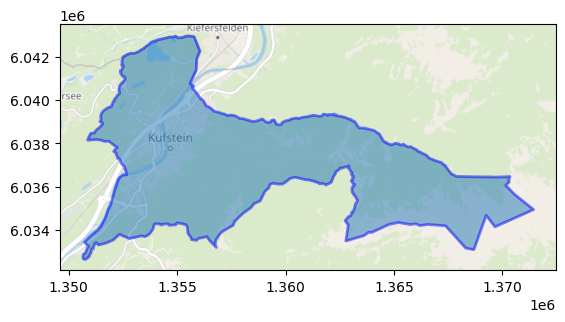

In [84]:
nominatim_area = input("Please enter the city, town or region you want to analyze: ")

# Nominatim query
gdf_area = osmnx.geocode_to_gdf(nominatim_area)

# Plot the area
f, ax = plt.subplots()
gdf_area.to_crs(epsg=3857).plot(ax=ax, alpha=0.5, edgecolor="b", linewidth=2)
cx.add_basemap(
    ax,
    source="https://tile.thunderforest.com/atlas/{z}/{x}/{y}.png?apikey=3ad11fafa2564c1183c66f15224857b5",
)

# Get the area as a GEOJSON file
gjson_area = gdf_area.to_json()
# areaID is always osm_id + 3600000000, has to be a relation, gdf_area.osm_id comes from osmnx nominatim query above
areaId = gdf_area.osm_id[0] + 3600000000

# Calculate the bounding box of the geometries
x_min, y_min, x_max, y_max = gdf_area.geometry.total_bounds
# Calculate the center of the bounding box for folium map starting position
folium_start_pos_x = (x_min + x_max) / 2
folium_start_pos_y = (y_min + y_max) / 2

⏩ Optionally, you can enter the EPSG Code (in format *EPSG:4258*) for your prefered **Coordinate Reference System**, but it is recommended to leave it as it is because the best CRS is selected automatically (in UTM CRS). If you really want to choose your own CRS, **be aware that the units depend on the units of your CRS**. It is strongly recommended that if you're using your own CRS, you are selecting one with metres as unit so that the calculations and evaluations are correct.

In [85]:
crs = ""
if not crs:
    # Project area with OSMNX automatically and take CRS attribute if no CRS is given
    gdf_area_crs = osmnx.projection.project_gdf(gdf_area)
    crs = gdf_area_crs.crs
else:
    # Grid to own CRS
    gdf_area_crs = osmnx.projection.project_gdf(gdf_area, to_crs=crs)
    crs = gdf_area_crs.crs

# P3: Load and Preprocess OSM Data

## Overpass Queries

Overpass is a web API that allows users to get and **filter specific OSM features**. It has its own [query language](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL).

All queries are already defined and nothing needs to be done anymore. But if you want to analyse **your own set of OSM attributes** (for example, all one-way streets where bicycles can also travel against the one-way traffic flow), you can define and analyse your own infrastructure class.  You can use the Overpass [Turbo Wizard](https://overpass-turbo.eu/) to do this. However, the query output should be in XML format `[out:xml] ` and return also metadata `out meta;` so it should look like this:
```[out:xml][timeout:200];
area(id:{areaId})->.searchArea;
(
  FEATURES SETS HERE
);
(._;>;);
out meta;
```



In [86]:
#### OVERPASS QUERYS ####

### CYCLE LANES ###
query_cycletracks = f"""
/*
“(highway=cycleway   OR (highway=path OR highway= footway) AND (bicycle=designated OR bicycle=yes OR bicycle=permissive)  OR (cycleway=track OR cycleway=opposite_track)  OR (cycleway:right=track OR cycleway:right=opposite_track)  OR (cycleway:left=track OR cycleway:left=opposite_track)  OR (cycleway:both=track OR cycleway:both=opposite_track) ) in Innsbruck”
*/
[out:xml][timeout:200];
area(id:{areaId})->.searchArea;
(
  way["highway"="cycleway"](area.searchArea);
  way["highway"="path"]["bicycle"="designated"](area.searchArea);
  way["highway"="path"]["bicycle"="yes"](area.searchArea);
  way["highway"="path"]["bicycle"="permissive"](area.searchArea);
  way["highway"="footway"]["bicycle"="designated"](area.searchArea);
  way["highway"="footway"]["bicycle"="yes"](area.searchArea);
  way["highway"="footway"]["bicycle"="permissive"](area.searchArea);
  way["cycleway"="track"](area.searchArea);
  way["cycleway"="opposite_track"](area.searchArea);
  way["cycleway:right"="track"](area.searchArea);
  way["cycleway:right"="opposite_track"](area.searchArea);
  way["cycleway:left"="track"](area.searchArea);
  way["cycleway:left"="opposite_track"](area.searchArea);
  way["cycleway:both"="track"](area.searchArea);
  way["cycleway:both"="opposite_track"](area.searchArea);
);
(._;>;);
out meta;
"""
### CYCLE LANES ###
query_cyclelanes= f"""
/*
“(cycleway=lane OR cycleway=opposite_lane) OR (cycleway:right=lane OR cycleway:right=opposite_lane) OR (cycleway:left=lane OR cycleway:left=opposite_lane) OR (cycleway:both=lane OR cycleway:both=opposite_lane) in Innsbruck”
*/
[out:xml][timeout:200];
area(id:{areaId})->.searchArea;
(
  way["cycleway"="lane"](area.searchArea);
  way["cycleway"="opposite_lane"](area.searchArea);
  way["cycleway:right"="lane"](area.searchArea);
  way["cycleway:right"="opposite_lane"](area.searchArea);
  way["cycleway:left"="lane"](area.searchArea);
  way["cycleway:left"="opposite_lane"](area.searchArea);
  way["cycleway:both"="lane"](area.searchArea);
  way["cycleway:both"="opposite_lane"](area.searchArea);
);
(._;>;);
out meta;
"""

### CALM TRAFFIC WAYS ####
query_calmtrafficways= f"""
/*
The original search was:
“(  (highway=track OR highway=service OR highway=unclassified OR highway=residential) AND bicycle!=* AND (motor_vehicle=private OR motor_vehicle=no OR motor_vehicle=customers OR motor_vehicle=agricultural OR motor_vehicle=forestry OR motor_vehicle=destination OR motor_vehicle=delivery) ) OR  (  (highway=track OR highway=service OR highway=unclassified OR highway=residential) AND ( (motor_vehicle=private OR motor_vehicle=no OR motor_vehicle=customers OR motor_vehicle=agricultural OR motor_vehicle=forestry OR motor_vehicle=destination OR motor_vehicle=delivery) OR (access=private OR access=no OR access=customers OR access=agricultural OR access=forestry OR access=destination OR access=delivery) OR (vehicle=private OR vehicle=no OR vehicle=customers OR vehicle=agricultural OR vehicle=forestry OR vehicle=destination OR vehicle=delivery) ) AND (bicycle=designated OR bicycle=yes OR bicycle=permissive) ) OR ( highway=track  AND (bicycle=designated OR bicycle=yes OR bicycle=permissive) AND (motor_vehicle!=* AND access!=* AND vehicle!=*) ) OR ( highway=living_street ) OR ( bicycle_road=yes ) OR ( highway=pedestrian  AND (bicycle=designated OR bicycle=yes OR bicycle=permissive) )”
*/
[out:xml][timeout:240];
area(id:{areaId})->.searchArea;
(
way["highway"="track"]["bicycle"!~".*"]["motor_vehicle"="private"](area.searchArea);
way["highway"="track"]["bicycle"!~".*"]["motor_vehicle"="no"](area.searchArea);
way["highway"="track"]["bicycle"!~".*"]["motor_vehicle"="customers"](area.searchArea);
way["highway"="track"]["bicycle"!~".*"]["motor_vehicle"="agricultural"](area.searchArea);
way["highway"="track"]["bicycle"!~".*"]["motor_vehicle"="forestry"](area.searchArea);
way["highway"="track"]["bicycle"!~".*"]["motor_vehicle"="destination"](area.searchArea);
way["highway"="track"]["bicycle"!~".*"]["motor_vehicle"="delivery"](area.searchArea);
way["highway"="service"]["bicycle"!~".*"]["motor_vehicle"="private"](area.searchArea);
way["highway"="service"]["bicycle"!~".*"]["motor_vehicle"="no"](area.searchArea);
way["highway"="service"]["bicycle"!~".*"]["motor_vehicle"="customers"](area.searchArea);
way["highway"="service"]["bicycle"!~".*"]["motor_vehicle"="agricultural"](area.searchArea);
way["highway"="service"]["bicycle"!~".*"]["motor_vehicle"="forestry"](area.searchArea);
way["highway"="service"]["bicycle"!~".*"]["motor_vehicle"="destination"](area.searchArea);
way["highway"="service"]["bicycle"!~".*"]["motor_vehicle"="delivery"](area.searchArea);
way["highway"="unclassified"]["bicycle"!~".*"]["motor_vehicle"="private"](area.searchArea);
way["highway"="unclassified"]["bicycle"!~".*"]["motor_vehicle"="no"](area.searchArea);
way["highway"="unclassified"]["bicycle"!~".*"]["motor_vehicle"="customers"](area.searchArea);
way["highway"="unclassified"]["bicycle"!~".*"]["motor_vehicle"="agricultural"](area.searchArea);
way["highway"="unclassified"]["bicycle"!~".*"]["motor_vehicle"="forestry"](area.searchArea);
way["highway"="unclassified"]["bicycle"!~".*"]["motor_vehicle"="destination"](area.searchArea);
way["highway"="unclassified"]["bicycle"!~".*"]["motor_vehicle"="delivery"](area.searchArea);
way["highway"="residential"]["bicycle"!~".*"]["motor_vehicle"="private"](area.searchArea);
way["highway"="residential"]["bicycle"!~".*"]["motor_vehicle"="no"](area.searchArea);
way["highway"="residential"]["bicycle"!~".*"]["motor_vehicle"="customers"](area.searchArea);
way["highway"="residential"]["bicycle"!~".*"]["motor_vehicle"="agricultural"](area.searchArea);
way["highway"="residential"]["bicycle"!~".*"]["motor_vehicle"="forestry"](area.searchArea);
way["highway"="residential"]["bicycle"!~".*"]["motor_vehicle"="destination"](area.searchArea);
way["highway"="residential"]["bicycle"!~".*"]["motor_vehicle"="delivery"](area.searchArea);
way["highway"="track"]["motor_vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["motor_vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["motor_vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["motor_vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["motor_vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["motor_vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["motor_vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["motor_vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["motor_vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["motor_vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["motor_vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["motor_vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["motor_vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["motor_vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["motor_vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["motor_vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["motor_vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["motor_vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["motor_vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["motor_vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["motor_vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["access"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["access"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["access"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["access"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["access"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["access"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["access"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["access"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["access"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["access"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["access"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["access"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["access"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["access"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["access"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["access"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["access"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["access"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["access"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["access"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["access"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="track"]["vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="track"]["vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["motor_vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["motor_vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["motor_vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["motor_vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["motor_vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["motor_vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["motor_vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["motor_vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["motor_vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["motor_vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["motor_vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["motor_vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["motor_vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["motor_vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["motor_vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["motor_vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["motor_vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["motor_vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["motor_vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["motor_vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["motor_vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["access"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["access"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["access"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["access"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["access"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["access"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["access"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["access"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["access"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["access"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["access"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["access"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["access"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["access"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["access"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["access"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["access"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["access"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["access"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["access"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["access"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="service"]["vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="service"]["vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="service"]["vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["motor_vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["access"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["access"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["access"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["access"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["access"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["access"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["access"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["access"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["access"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["access"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["access"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["access"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["access"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["access"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["access"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["access"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["access"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["access"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["access"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["access"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["access"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="unclassified"]["vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="unclassified"]["vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="unclassified"]["vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["motor_vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["access"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["access"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["access"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["access"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["access"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["access"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["access"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["access"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["access"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["access"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["access"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["access"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["access"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["access"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["access"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["access"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["access"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["access"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["access"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["access"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["access"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["vehicle"="private"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["vehicle"="private"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["vehicle"="private"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["vehicle"="no"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["vehicle"="no"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["vehicle"="no"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["vehicle"="customers"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["vehicle"="customers"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["vehicle"="customers"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["vehicle"="agricultural"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["vehicle"="agricultural"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["vehicle"="agricultural"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["vehicle"="forestry"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["vehicle"="forestry"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["vehicle"="forestry"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["vehicle"="destination"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["vehicle"="destination"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["vehicle"="destination"]["bicycle"="permissive"](area.searchArea);
way["highway"="residential"]["vehicle"="delivery"]["bicycle"="designated"](area.searchArea);
way["highway"="residential"]["vehicle"="delivery"]["bicycle"="yes"](area.searchArea);
way["highway"="residential"]["vehicle"="delivery"]["bicycle"="permissive"](area.searchArea);
way["highway"="track"]["bicycle"="designated"]["motor_vehicle"!~".*"]["access"!~".*"]["vehicle"!~".*"](area.searchArea);
way["highway"="track"]["bicycle"="yes"]["motor_vehicle"!~".*"]["access"!~".*"]["vehicle"!~".*"](area.searchArea);
way["highway"="track"]["bicycle"="permissive"]["motor_vehicle"!~".*"]["access"!~".*"]["vehicle"!~".*"](area.searchArea);
way["highway"="living_street"]["area"!="yes"](area.searchArea);
way["bicycle_road"="yes"](area.searchArea);
way["highway"="pedestrian"]["bicycle"="designated"]["area"!="yes"](area.searchArea);
way["highway"="pedestrian"]["bicycle"="yes"]["area"!="yes"](area.searchArea);
way["highway"="pedestrian"]["bicycle"="permissive"]["area"!="yes"](area.searchArea);
);
(._;>;);
out meta;
"""

## Download OSM Data

The data is retrieved from OSM using the Overpass API and the appropriate queries.

In [87]:
"""
A dictionary with all data for each infrastructure class is created.
The dictionary for each 'infr_class' can contains the following elements:

- 'query': The query statement to retrieve data.
- 'name': The name of the infrastructure class.
- 'graph': routable directed OSMNX graph. 
  This graph is routable and represents the infrastructure in both directions (i.e. if edges are bidirectional, they exist twice). 
  It is projected and clipped to the study area at the next edge outside the study area.
- 'gdf_xml': A separate GeoDataFrame directly from the XML file. This GeoDataFrame includes 'version' and 'timestamp' columns,
  which are part of the Overpass API's meta output. Note that OSMNX does not provide this metadata. However, the XML-derived
  GeoDataFrame is not routable and contains the original number of OSM features. The nodes which were used for OSMNX will be excluded
  to prevent errors, if there are no features a empty GDF is created. 
  It is projected and clipped to the study area directly where the study area polygon intersects the features with a buffer tolerance of 1.5m.
"""

dict_osm_cycle_tracks = {
    "query": query_cycletracks,
    "name": "cycle_tracks",
    "graph": "",
}
dict_osm_cycle_lanes = {
    "query": query_cyclelanes, 
    "name": "cycle_lanes", 
    "graph": ""
}
dict_osm_calm_traffic_ways = {
    "query": query_calmtrafficways,
    "name": "calm_traffic_ways",
    "graph": "",
    "gdf_xml": "",
}
ls_classes = [dict_osm_cycle_tracks, dict_osm_cycle_lanes, dict_osm_calm_traffic_ways]

# Set useful tags to add them to the osmnx graph for further evaluations
osmnx.settings.useful_tags_way += [
    "lane",
    "track",
    "opposite_track",
    "opposite_lane",
    "cycleway",
    "cycleway:right",
    "cycleway:left",
    "cycleway:both",
]

# Call Overpass API, built a OSMNX graph and a GeoDataFrame and update the dictionary with 'to_data_dict'
ls_classes = to_data_dict(
    ls_classes=ls_classes,
    area_name=nominatim_area,
    diskpath=diskpath,
    clip=True,
    crs=crs,
    gdf_area=gdf_area_crs,
)

In [88]:
"""
Additionally a dictionary for all infr_classes together (total amount of features) is created, it contains the following elements:

- 'name': The name of the infrastructure class.
- 'graph': routable directed OSMNX graph. 
  This graph is routable and represents the infrastructure in both directions (i.e. if edges are bidirectional, they exist twice).
  Like the other graphs it is projected and clipped to the study area at the next edge outside the study area.
- 'gdf_xml': A separate GeoDataFrame directly from the XML file. This GeoDataFrame includes 'version' and 'timestamp' columns,
  which are part of the Overpass API's meta output. Note that osmnx does not provide this metadata. However, the XML-derived
  GeoDataFrame is not routable and contains the original number of OSM features. The nodes which were used for osmnx will be excluded.
  To prevent errors, if there are no features a empty GDF is created.
  Like the other GDFs, it is projected and clipped to the study area directly where the study area polygon intersects the features with a buffer tolerance of 1.5m.
- 'gdf_xml_dt': same as gdf_xml but with datetime objects; folium can't handle datetime objects so there is a own gdf
"""

dict_osm_total = {
    "name": "Total Bicycle Infrastructure",
    "graph": "",
    "gdf_xml": "",
    "gdf_xml_dt": "",
}

# Create a list of non-empty MultiDiGraphs created in the section above
Gs = [
    dict_osm_cycle_tracks["graph"],
    dict_osm_cycle_lanes["graph"],
    dict_osm_calm_traffic_ways["graph"],
]
Gs_valid = [x for x in Gs if x]  # only non-empty graphs allowed

#### Graph ####
# Combine the Graphs together into one if Gs_valid is not empty
if Gs_valid:
    dict_osm_total["graph"] = nx.compose_all(Gs_valid)
else:
    raise ValueError("NO INFRASTRUCTURE IN YOUR STUDY AREA. STOPPING SCRIPT.")

#### GDF XML ####
# New column with infrastructure class to distinguish infr_classes in total gdf
dict_osm_cycle_tracks["gdf_xml"]["infr_class"] = "Cycle Tracks"
dict_osm_cycle_lanes["gdf_xml"]["infr_class"] = "Cycle Lanes"
dict_osm_calm_traffic_ways["gdf_xml"]["infr_class"] = "Calm Traffic Ways"

# Combine all classes in one GDF
dict_osm_total["gdf_xml"] = gpd.GeoDataFrame(
    pd.concat(
        [
            dict_osm_cycle_tracks["gdf_xml"],
            dict_osm_cycle_lanes["gdf_xml"],
            dict_osm_calm_traffic_ways["gdf_xml"],
        ],
        ignore_index=True,
    ),
    crs=[dict_osm_cycle_tracks["gdf_xml"], dict_osm_cycle_lanes["gdf_xml"]][0].crs,
)

#### GDF XML DT ####
# Convert timestamp to datetime object in a new gdf because folium can't handle datetime objects
dict_osm_total["gdf_xml_dt"] = dict_osm_total["gdf_xml"].copy()
# Convert timestamp to date
dict_osm_total["gdf_xml_dt"].timestamp = pd.to_datetime(
    dict_osm_total["gdf_xml_dt"].timestamp
)

Convert possible MultiLinestrings and Polygons into LineStrings and drop geometries other than Linestring.

Also, in some rare cases, there can be duplicates. This is the case when a LineString is classified in more than one infrastructure class (for example, because a street is a calm traffic way and has in addition cycle lanes).

In [89]:
# Convert possible MultiLineStrings and Polygons to LineStrings at the XML (non graph) GeoDataFrames
# The graph should be processed by OSMNX correctly
dict_osm_total["gdf_xml"] = to_linestring(dict_osm_total["gdf_xml"])
dict_osm_total["gdf_xml_dt"] = to_linestring(dict_osm_total["gdf_xml_dt"])

dict_osm_cycle_tracks["gdf_xml"] = to_linestring(dict_osm_cycle_tracks["gdf_xml"])
dict_osm_cycle_lanes["gdf_xml"] = to_linestring(dict_osm_cycle_lanes["gdf_xml"])
dict_osm_calm_traffic_ways["gdf_xml"] = to_linestring(
    dict_osm_calm_traffic_ways["gdf_xml"]
)

# Drop duplicates in the GeoDataFrames
if dict_osm_total["gdf_xml"].duplicated("geometry").any():
    print("Duplicates in GeodataFrame dropped.")
dict_osm_total["gdf_xml"].drop_duplicates(subset="geometry", keep="first", inplace=True)
dict_osm_total["gdf_xml_dt"].drop_duplicates(
    subset="geometry", keep="first", inplace=True
)

## Infrastructure Length vs. Geometry Length

<img src="https://i.imgur.com/kxSkubZ.png" alt="drawing" width="400"/>

In OSM, bicycle infrastructure can be mapped with its own geometry or with attributes on main roads. In the CycleOSM image above, the cycle track in the park has its own geometry, and the cycle track on the road from west to east is attached to the road geometry.

If a main road has two cycle lanes or cycle tracks (one for each direction), both will use the same geometry. This means that based on the attributes, the actual cycle infrastructure length can be twice as long than the geometry length. For more information see [cycle lanes](https://wiki.openstreetmap.org/wiki/Tag:cycleway%3Dlane) and [cycle tracks](https://wiki.openstreetmap.org/wiki/Tag:cycleway%3Dtrack) on the OSM wiki.


# P4: Load and Preprocess GIP Data

The data is retrieved from the official GIP data source, clipped, classified and used for further analysis. 

In [90]:
"""
All GIP data is stored in one dictionary. It is reprojected and clipped to the study area with a buffer tolerance of 1.5m  and contains:

- 'turnuse': Stores only TurnUse Linestrings. 
  TurnUse LineStrings are in the GIP model special Linestrings that connects the features (in this case radvis features) representing the edges at intersections (nodes).
- 'radvis': Stores only Radvis LineStrings
  Radvis LineStrings are edges which represents the bicycle infrastructure. They are segmented and not directly connected. With TurnUse LineStrings you can connect them.
- 'connected_radvis': Stores the node Edge Model, where Radvis features are connected with each other without original TurnUse Linestrings
  to get a classical Node Edge Model
"""

dict_gip = {
    "turnuse": "",
    "radvis": "",
    "connected_radvise": "",
}

## Download GIP Data

The files are automatically downloaded and saved.

<big>⌛</big> The files have a size of ~2,5 GB, so depending on your Internet connection the download can take some time.<big>⌛</big>

In [91]:
try:
    urls = [
        "https://open.gip.gv.at/ogd/C_gip_reference_ogd.zip",
        "https://open.gip.gv.at/ogd/B_gip_network_ogd.zip",
    ]

    # Skip if already downloaded
    if os.path.exists(f"{diskpath}/gip_data/"):
        print(
            'GIP data folder already exists. Skipping download. \nIf you want to download again, delete the folder "gip_data" and run cell again.'
        )
    else:
        for url in urls:
            
            path = f"{diskpath}/gip_data/"
            download_file(url)
except:
    print(f"""GIP server not available. Try to execute the notebook again or to download the files
            https://open.gip.gv.at/ogd/C_gip_reference_ogd.zip,
            https://open.gip.gv.at/ogd/B_gip_network_ogd.zip
            manually and upload/put them to folder '{diskpath}/gip_data' """)

GIP data folder already exists. Skipping download. 
If you want to download again, delete the folder "gip_data" and run cell again.


<big>⌛</big> Loading GIP data into notebook can take up to five minutes, depending on the amount of RAM you have!<big>⌛</big>

In [92]:
# Read downloaded GIP data from the extracted files into GeoDataFrames
gdf_radvis = gpd.read_file(
    f"{diskpath}/gip_data/gip_reference_ogd.gpkg", layer="RADVIS", engine="pyogrio"
)
gdf_turnuse = gpd.read_file(
    f"{diskpath}/gip_data/gip_network_ogd.gpkg", layer="TURNUSE_OGD", engine="pyogrio"
)
gdf_linearuse = gpd.read_file(
    f"{diskpath}/gip_data/gip_network_ogd.gpkg", layer="LINEARUSE_OGD", engine="pyogrio"
)
gdf_gip_nodes = gpd.read_file(
    f"{diskpath}/gip_data/gip_network_ogd.gpkg", layer="NODE_OGD", engine="pyogrio"
)

## Clip and Reclassification of GIP Data

The GIP data is clipped to your defined area and filtered to retain only certain pre-defined values of cycling infrastructure. Classes such as bus lanes or one-way cycle lanes open to bikes are excluded because they are difficult to analyse and cannot be considered as infrastructure primarily for cycling. These values will be kept and used for the final classification:

Kept and classified as calm traffic ways will be:
<small>
* BGZ - Begegnungszone
* FRS - Fahrradstraße
* FUZO - Radfahren in Fußgängerzonen
* FUZO_N - Radfahren in Fußgängerzonen (Nebenfahrbahn)
* VK_BE - Verkehrsberuhigte Bereiche
* WSTR - Radfahren in Wohnstraßen
* WSTR_N - Radfahren in Wohnstraßen (Nebenfahrbahn)
* RVW - Radfahren auf verkehrsarmen Wegen (unbefestigter Weg)
</small>

Kept and classified as cycle tracks will be:
<small>
* GRW_M - Gemischter Geh- und Radweg
* GRW_MO - Gemischter Geh- und Radweg ohne Benützungspflicht
* GRW_T - Getrennter Geh- und Radweg
* GRW_TO - Getrennter Geh- und Radweg ohne Benützungspflicht
* GRW_MV - Gemischter Geh- und Radweg verordnet (nur Visualisierung)
* GRW_MOV - Gemischter Geh- und Radweg ohne Benützungspflicht verordnet (nur Visualisierung)
* RW - Baulicher Radweg
* RWO - Radweg ohne Benützungspflicht
* RFUE - Radfahrerüberfahrt
* SCHUTZWEG_RFUE - Querung Schutzweg und Radfahrüberfahrt
* TRR - Treppe auch für Radfahrer geeignet
* SGT - Singletrail
* MTB - Mountainbikestrecke (Radfahren im Wald)
</small>

Kept and classified as cycle lanes will be:
<small>
* MZSTR - Mehrzweckstreifen
* RF - Radfahrstreifen
</small>

Excluded will be:
<small>
* RFGE - Radfahren gegen die Einbahn
* RFGE_N - Radfahren gegen die Einbahn (Nebenfahrbahn)
* RR - Radroute (beschilderte Route, Radverkehr wird im Mischverkehr geführt)
* RRN - Hauptradroute
* TRF - Trasse nur für Fußgänger
* BS - Radfahren auf Busspuren
* FE - Fähre
* ABBK - Anrainerstraße Radverkehr
</small>

In [93]:
# Buffer gdf_area in projected crs to clip GIP data, project back to WGS84 to clip GIP data immediately
gdf_area_buffered = gdf_area_crs.geometry.buffer(1.5)
gdf_area_buffered = osmnx.projection.project_gdf(gdf_area_buffered, to_crs="EPSG:4326")

# Clip data to area mask with buffer tolerance 1.5m
gdf_radvis = gpd.clip(gdf_radvis, gdf_area_buffered)
gdf_turnuse = gpd.clip(gdf_turnuse, gdf_area_buffered)
gdf_linearuse = gpd.clip(gdf_linearuse, gdf_area_buffered)
gdf_gip_nodes = gpd.clip(gdf_gip_nodes, gdf_area_buffered)

# Every gdf to projected crs
gdf_radvis = osmnx.projection.project_gdf(gdf_radvis, to_crs=crs)
gdf_turnuse = osmnx.projection.project_gdf(gdf_turnuse, to_crs=crs)
gdf_linearuse = osmnx.projection.project_gdf(gdf_linearuse, to_crs=crs)
gdf_gip_nodes = osmnx.projection.project_gdf(gdf_gip_nodes, to_crs=crs)


# Clean radvis and keep only certain radvis classes (drop certain classes)
drop_radvis_classes = ["BS", "ABBK", "FE", "RFGE", "RFGE_N", "RR", "RRN", "TRF", "-"]
# drop when both bike_tow and bike_bkw are in drop_radvis_classes
mask = (gdf_radvis["bike_tow"].isin(drop_radvis_classes)) & (gdf_radvis["bike_bkw"].isin(drop_radvis_classes))
gdf_radvis_reclass = gdf_radvis[~mask]

# Clean turnuse and keep only turnuse features that connect to radvis bicycle infrastructure (gdf_radvis_reclass)
mask = gdf_turnuse.apply(clean_turnuse, axis=1, args=(gdf_radvis_reclass,))
gdf_turnuse_cleaned = gdf_turnuse[mask]

# Add (join) timestamp to radvis gdf from linearuse dataset
if "TIMESTAMP" in gdf_radvis_reclass.columns:
    print("TIMESTAMP already in gdf_linearuse")
else:
    gdf_radvis_reclass = gdf_radvis_reclass.merge(
        gdf_linearuse[["WIDTHAVERAGE", "TIMESTAMP", "OBJECTID"]],
        how="left",
        right_on="OBJECTID",
        left_on="gip_lu_id",
    )

# It's not possible to execute the script if there is no GIP data at all
if gdf_radvis.empty:
    raise ValueError("NO GIP DATA IN YOUR STUDY AREA. STOPPING SCRIPT.")

### Reclassification and different infrastructure values depending on the direction of travel

The GIP dataset has two values for the bicycle infrastructure, one for each direction (`bike_tow`/ `bike_bkw` columns).

Feature objects that have just one value that is on the exclude list above or have a `None` value and a second valid value, the second valid value is used as the general value (for both directions) for classification.

If a feature has different values in the forward and reverse directions, which conflicts between the three main classes (Cycle Lanes, Cycle Tracks, Calm Traffic Ways), it is classified as None value (`np.nan`). In most cases this is a data entry error in the GIP data.

In [94]:
# Clean GeoDataFrame and reclassify into new classes defined also
gdf_radvis_reclass = gdf_radvis_reclass.apply(classify_infr_class_gip, axis=1)

Also convert any MultiLineStrings and polygons to LineStrings and drop geometries other than LineStrings

In [95]:
# Convert possible MultiLineStrings and Polygons to LineStrings at the GeoDataFrames
gdf_radvis_reclass = to_linestring(gdf_radvis_reclass)
gdf_turnuse_cleaned = to_linestring(gdf_turnuse_cleaned)

## Topological Models

The GIP dataset of the cycling infrastructure is not available as a Node Edge model. It is first necessary to model it in this way.

In this notebook, in contrast to the others, only the Node Edge Model is available for the matching and conflation processes, as it demonstrates the most optimal results.

In [96]:
gdf_connected_node_radvis, coords_mostturnuses = create_node_edge_model(
    gdf_radvis_reclass, gdf_turnuse_cleaned, gdf_gip_nodes, mostturnuses=True
)

In [97]:
#### LENGTH OF GEOMETRY AND FILLING DICTIONARY WITH DATA ####
# Calculate the length of the geometry, this datasets are used in length evaluations
gdf_radvis_reclass["geom_length"] = gdf_radvis_reclass.geometry.length
gdf_connected_node_radvis["geom_length"] = gdf_connected_node_radvis.geometry.length

# Fill the dictionary with the data
dict_gip["turnuse"] = gdf_turnuse_cleaned
dict_gip["radvis"] = gdf_radvis_reclass
dict_gip["connected_radvise"] = gdf_connected_node_radvis

# Convert possible MultiLineStrings and Polygons to LineStrings at the GeoDataFrames at new constructed model again
dict_gip["connected_radvise"] = to_linestring(dict_gip["connected_radvise"])

# P5: Feature Matching

The feature matching process checks which bicycle infrastructure is present in both datasets. 
This allows statements to be made about the completeness of the datasets and provides a subset of features that have been confirmed by the other dataset. It should be noted that the feature matching process only evaluates the geometry, not the thematic accuracy or completeness of the attributes of the features in the datasets.

The feature matching of disparate datasets represents a distinct area of research in its own right. The matching algorithm in this notebook was taken from:
* Vierø A. R., Vybornova A., Szell M. (2023). BikeDNA: A tool for bicycle infrastructure data and network assessment. Environment and Planning B: Urban Analytics and City Science. https://doi.org/10.1177/23998083231184471

And the authors of the matching algorithm were inspired by:
* Will, J. (2014). Development of an automated matching algorithm to assess the quality of the OpenStreetMap road network : a case study in Göteborg, Sweden. Student thesis series Ines. https://lup.lub.lu.se/luur/download?fileOId=4466312&func=downloadFile&recordOId=4464336
* Koukoletsos T. , Haklay M.,  Ellu C. (2011). An automated method to assess Data Completeness and Positional Accuracy of OpenStreetMap. GeoComputation 2011. https://www.geog.leeds.ac.uk/groups/geocomp/2011/papers/koukoletsos.pdf

## Define Matching Parameters

The feature matching process is based on four parameters that you can define.

* Segment length: Before matching, all features are divided into segments. These segments are compared and for each segment the best matching segment in the other dataset is found. The smaller the segments, the longer the matching process.
* Buffer distance: Maximum distance that corresponding matches can be from each other.
* Maximum Hausdorff distance: The Hausdorff distance is a geometric measurement that measures the maximum deviation between two  mathematical subsets. In this case the subsets are LineString features. In contrast to a simple euclidean  distance, with Hausdorff distance it's possible to take also the shape of features into account when measuring the distance to each other. The higher the threshold, the more segments are matched. For more background information, see the related [Wikipedia article](https://en.wikipedia.org/wiki/Hausdorff_distance).
* Angular Threshold: The maximum angle between two potential segments. Segments above this threshold are excluded from the matching process. The higher the threshold, the longer the process takes.

The default settings take into account the potential width of multi-lane roads (to match also segments modeled in different ways), bicycle networks with more fragmented parts (hence a rather low segment length) and segments, especially GIP segments, which have a wide orientation at intersections compared to the actual road (hence a rather high angular threshold).

At the same time, it is important to approach feature matching as an iterative process, as the matching process is not perfect when comparing two different datasets.
So try using the default settings first, check the results, and then revise the settings if necessary.

In [121]:
# Define widgets without descriptions
w_segment_length = BoundedFloatText(value=8, disabled=False)
w_buffer_distance = BoundedFloatText(value=13, disabled=False)
w_hausdorff = BoundedFloatText(value=15, disabled=False)
w_angular = BoundedFloatText(value=55, disabled=False)


# Display the custom labeled widgets
print("Segment Length (in m):")
display(w_segment_length)
print("Buffer Distance (in m):")
display(w_buffer_distance)
print("Hausdorf Threshold (in m):")
display(w_hausdorff)
print("Angular Threshold (in degree):")
display(w_angular)
print(
    "\nAdjust the parameters for the matching process and if needed run the process from the next cell on again."
)

Segment Length (in m):


BoundedFloatText(value=8.0)

Buffer Distance (in m):


BoundedFloatText(value=13.0)

Hausdorf Threshold (in m):


BoundedFloatText(value=15.0)

Angular Threshold (in degree):


BoundedFloatText(value=55.0)


Adjust the parameters for the matching process and if needed run the process from the next cell on again.


In [99]:
segment_length = int(w_segment_length.value)
buffer_dist = int(w_buffer_distance.value)
hausdorff_threshold = int(w_hausdorff.value)
angular_threshold = int(w_angular.value)

## Feature Matching GIP

In [100]:
# Select gdfs to match and create a unique edge id for each edge
gip_edges = dict_gip["connected_radvise"]
osm_edges = dict_osm_total["gdf_xml_dt"]

# Create edge_ids for each OSM and GIP features
osm_edges['edge_id'] = osm_edges.apply(lambda row: hash(str(row)), axis=1)
gip_edges['edge_id'] = gip_edges.apply(lambda row: hash(str(row)), axis=1)


# Create edge segments for OSM and GIP data
# Osmid: Because matching function assumes an id column names osmid as unique id for edges
osm_segments = create_segment_gdf(osm_edges, segment_length=segment_length)
osm_segments.rename(columns={"osmid": "org_osmid"}, inplace=True)
osm_segments["osmid"] = osm_segments["edge_id"]  
osm_segments.set_crs(crs, inplace=True)
osm_segments.dropna(subset=["geometry"], inplace=True)

gip_segments = create_segment_gdf(gip_edges, segment_length=segment_length)
gip_segments.set_crs(crs, inplace=True)
gip_segments.rename(columns={"seg_id": "seg_id_ref"}, inplace=True)
gip_segments.dropna(subset=["geometry"], inplace=True)

<big>⌛</big> The feature matching can take up to ten minutes and more on very large citys!<big>⌛</big>

In [101]:
# Calculate buffer matches with overlay_buffer() and find best matches with find_matches_from_buffer()
print(
    f"Start matching using a buffer distance of {buffer_dist} meters, a Hausdorff distance of {hausdorff_threshold} meters, and a max angle of {angular_threshold} degrees."
)
buffer_matches = overlay_buffer(
    reference_data=gip_segments,
    osm_data=osm_segments,
    ref_id_col="seg_id_ref",
    osm_id_col="seg_id",
    dist=buffer_dist,
)

segment_matches = find_matches_from_buffer(
    buffer_matches=buffer_matches,
    osm_edges=osm_segments,
    reference_data=gip_segments,
    angular_threshold=angular_threshold,
    hausdorff_threshold=hausdorff_threshold,
)

# Create a GeoDataFrame based on matched segments id
gip_matched_segments = segment_matches
gip_unmatched_segments = gip_segments.loc[
    ~gip_segments.seg_id_ref.isin(segment_matches.seg_id_ref)
]

Start matching using a buffer distance of 13 meters, a Hausdorff distance of 15 meters, and a max angle of 55 degrees.
3995 reference segments were matched
2994 segments were not matched


In [102]:
# Folium map matches GIP
match_map_gip = folium.Map(
    location=[folium_start_pos_y, folium_start_pos_x],
    tiles=thunderforestatlas,
    name="TF OSM Atlas",
    zoom_start=12,
)

# Add imagery base layer
folium.raster_layers.TileLayer(opencyclemap, show=False, name="OpenCycleMap").add_to(
    match_map_gip
)
folium.raster_layers.TileLayer(basemapat, show=False, name="Basemap.at").add_to(
    match_map_gip
)
folium.raster_layers.TileLayer(esri, show=False, name="Esri World Imagery").add_to(
    match_map_gip
)
folium.raster_layers.TileLayer(cyclosm, show=False, name="CycleOsm").add_to(
    match_map_gip
)

# Load gdfs as geojson; matched and unmatched segments for every infrastructure class
# Total Infrastructure
folium.GeoJson(
    gip_matched_segments.geometry,
    style_function=lambda feature: {
        "color": "green",
    },
    name="Matched Total GIP",
).add_to(match_map_gip)
folium.GeoJson(
    gip_unmatched_segments.geometry,
    style_function=lambda feature: {
        "color": "red",
    },
    name="Unmatched Total GIP",
).add_to(match_map_gip)
# Cycle Tracks
folium.GeoJson(
    gip_matched_segments.geometry.loc[
        gip_matched_segments["infr_class"] == "Cycle Tracks"
    ],
    style_function=lambda feature: {
        "color": color_cycle_tracks,
    },
    name="Matched Cylce Tracks GIP",
    show=False,
).add_to(match_map_gip)
folium.GeoJson(
    gip_unmatched_segments.geometry.loc[
        gip_unmatched_segments["infr_class"] == "Cycle Tracks"
    ],
    style_function=lambda feature: {
        "color": "#d74949",
    },
    name="Unmatched Cycle Tracks GIP",
    show=False,
).add_to(match_map_gip)
# Cycle Lanes
folium.GeoJson(
    gip_matched_segments.geometry.loc[
        gip_matched_segments["infr_class"] == "Cycle Lanes"
    ],
    style_function=lambda feature: {
        "color": color_cycle_lanes,
    },
    name="Matched Cyle Lanes GIP",
    show=False,
).add_to(match_map_gip)
folium.GeoJson(
    gip_unmatched_segments.geometry.loc[
        gip_unmatched_segments["infr_class"] == "Cycle Lanes"
    ],
    style_function=lambda feature: {
        "color": "#d74949",
    },
    name="Unmatched Cycle Lanes GIP",
    show=False,
).add_to(match_map_gip)
# Calm Traffic Ways
folium.GeoJson(
    gip_matched_segments.geometry.loc[
        gip_matched_segments["infr_class"] == "Calm Traffic Ways"
    ],
    style_function=lambda feature: {
        "color": color_calm_traffic_ways,
    },
    name="Matched Calm Traffic Ways GIP",
    show=False,
).add_to(match_map_gip)
folium.GeoJson(
    gip_unmatched_segments.geometry.loc[
        gip_unmatched_segments["infr_class"] == "Calm Traffic Ways"
    ],
    style_function=lambda feature: {
        "color": "#d74949",
    },
    name="Unmatched Calm Traffic Ways GIP",
    show=False,
).add_to(match_map_gip)
# OSM Features for comparison
folium.GeoJson(
    dict_osm_total['gdf_xml'].geometry,
    style_function=lambda feature: {
        "color": "black",
        "weight": 1
    },
    name="Total OSM Features",
    show=False
).add_to(match_map_gip)

# Add zoomtoggler to forbidd mouse toggling/scrolling
folium.plugins.ScrollZoomToggler().add_to(match_map_gip)
# Add layer control
folium.LayerControl().add_to(match_map_gip)

os.makedirs("./maps", exist_ok=True)
match_map_gip.save("./maps/match_map_gip.html")
match_map_gip

## Feature Matching OSM

In [103]:
# IMPORTANT:
# Calculate Matches again for OSM and switch the order of the datasets.
# The matching results are better when calculated for each dataset separately.

# Select gdfs to match and create a unique edge id for each edge
gip_edges = dict_osm_total['gdf_xml']
osm_edges = dict_gip['connected_radvise']

# Create edge_ids for each OSM and GIP features
osm_edges['edge_id'] = osm_edges.apply(lambda row: hash(str(row)), axis=1)
gip_edges['edge_id'] = gip_edges.apply(lambda row: hash(str(row)), axis=1)


# Create edge segments for OSM and GIP data
# Osmid: Because matching function assumes an id column names osmid as unique id for edges
osm_segments = create_segment_gdf(osm_edges, segment_length=segment_length)
osm_segments.rename(columns={"osmid": "org_osmid"}, inplace=True)
osm_segments["osmid"] = osm_segments["edge_id"]
osm_segments.set_crs(crs, inplace=True)
osm_segments.dropna(subset=["geometry"], inplace=True)

gip_segments = create_segment_gdf(gip_edges, segment_length=segment_length)
gip_segments.set_crs(crs, inplace=True)
gip_segments.rename(columns={"seg_id": "seg_id_ref"}, inplace=True)
gip_segments.dropna(subset=["geometry"], inplace=True)

<big>⌛</big> The feature matching can take up to five minutes and more on large citys!<big>⌛</big>

In [104]:
# Calculate buffer matches with overlay_buffer() and find best matches with find_matches_from_buffer()
print(
    f"Start matching using a buffer distance of {buffer_dist} meters, a Hausdorff distance of {hausdorff_threshold} meters, and a max angle of {angular_threshold} degrees."
)
buffer_matches = overlay_buffer(
    reference_data=gip_segments,
    osm_data=osm_segments,
    ref_id_col="seg_id_ref",
    osm_id_col="seg_id",
    dist=buffer_dist,
)

segment_matches = find_matches_from_buffer(
    buffer_matches=buffer_matches,
    osm_edges=osm_segments,
    reference_data=gip_segments,
    angular_threshold=angular_threshold,
    hausdorff_threshold=hausdorff_threshold,
)

# Create a GeoDataFrame based on matched segments id
osm_matched_segments = segment_matches
osm_unmatched_segments = gip_segments.loc[
    ~gip_segments.seg_id_ref.isin(segment_matches.seg_id_ref)
]

Start matching using a buffer distance of 13 meters, a Hausdorff distance of 15 meters, and a max angle of 55 degrees.
3557 reference segments were matched
436 segments were not matched


In [105]:
# Folium map matches OSM
match_map_osm = folium.Map(
    location=[folium_start_pos_y, folium_start_pos_x],
    tiles=thunderforestatlas,
    name="TF OSM Atlas",
    zoom_start=12,
)

# Add imagery base layer
folium.raster_layers.TileLayer(opencyclemap, show=False, name="OpenCycleMap").add_to(
    match_map_osm
)
folium.raster_layers.TileLayer(basemapat, show=False, name="Basemap.at").add_to(
    match_map_osm
)
folium.raster_layers.TileLayer(esri, show=False, name="Esri World Imagery").add_to(
    match_map_osm
)
folium.raster_layers.TileLayer(cyclosm, show=False, name="CycleOsm").add_to(
    match_map_osm
)

# Load gdfs as geojson; matched and unmatched segments for every infrastructure class
# Total Infrastructure
folium.GeoJson(
    osm_matched_segments.geometry,
    style_function=lambda feature: {
        "color": "green",
    },
    name="Matched Total OSM",
).add_to(match_map_osm)
folium.GeoJson(
    osm_unmatched_segments.geometry,
    style_function=lambda feature: {
        "color": "red",
    },
    name="Unmatched Total OSM",
).add_to(match_map_osm)
# Cycle Tracks
folium.GeoJson(
    osm_matched_segments.geometry.loc[
        osm_matched_segments["infr_class"] == "Cycle Tracks"
    ],
    style_function=lambda feature: {
        "color": color_cycle_tracks,
    },
    name="Matched Cylce Tracks OSM",
    show=False,
).add_to(match_map_osm)
folium.GeoJson(
    osm_unmatched_segments.geometry.loc[
        osm_unmatched_segments["infr_class"] == "Cycle Tracks"
    ],
    style_function=lambda feature: {
        "color": "#d74949",
    },
    name="Unmatched Cycle Tracks OSM",
    show=False,
).add_to(match_map_osm)
# Cycle Lanes
folium.GeoJson(
    osm_matched_segments.geometry.loc[
        osm_matched_segments["infr_class"] == "Cycle Lanes"
    ],
    style_function=lambda feature: {
        "color": color_cycle_lanes,
    },
    name="Matched Cyle Lanes OSM",
    show=False,
).add_to(match_map_osm)
folium.GeoJson(
    osm_unmatched_segments.geometry.loc[
        osm_unmatched_segments["infr_class"] == "Cycle Lanes"
    ],
    style_function=lambda feature: {
        "color": "#d74949",
    },
    name="Unmatched Cycle Lanes OSM",
    show=False,
).add_to(match_map_osm)
# Calm Traffic Ways
folium.GeoJson(
    osm_matched_segments.geometry.loc[
        osm_matched_segments["infr_class"] == "Calm Traffic Ways"
    ],
    style_function=lambda feature: {
        "color": color_calm_traffic_ways,
    },
    name="Matched Calm Traffic Ways OSM",
    show=False,
).add_to(match_map_osm)
folium.GeoJson(
    osm_unmatched_segments.geometry.loc[
        osm_unmatched_segments["infr_class"] == "Calm Traffic Ways"
    ],
    style_function=lambda feature: {
        "color": "#d74949",
    },
    name="Unmatched Calm Traffic Ways OSM",
    show=False,
).add_to(match_map_osm)
# GIP Features for comparison
folium.GeoJson(
    dict_gip['connected_radvise'].geometry,
    style_function=lambda feature: {
        "color": "black",
        "weight": 1
    },
    name="Total GIP Features",
    show=False
).add_to(match_map_osm)

# Add zoomtoggler to forbidd mouse toggling/scrolling
folium.plugins.ScrollZoomToggler().add_to(match_map_osm)
# Add layer control
folium.LayerControl().add_to(match_map_osm)

os.makedirs("./maps", exist_ok=True)
match_map_osm.save("./maps/match_map_osm.html")
match_map_osm

# E1: Feature Matching Results

The matching results allow statements to be made about the completeness of the datasets. The following graphs illustrate the proportion of matching segments, indicating the percentage of the total number of segments that were matched.
However, since it must be assumed that both datasets contain errors and do not fully reflect reality, the best statements can be made in combination with each other.

If the first dataset shows a high degree of agreement with the second, but the second does not agree with the first, this may be due to either a lack of infrastructure in dataset one or an excess of infrastructure in dataset two. Both of these would be errors of completeness (i.e. errors of omission and commission). On the other hand, too many features (errors of commission) are perhaps better to proof and less common like errors of omission.

If the match between the two datasets is low, then both datasets can be considered as bad quality. However, a lower level of agreement in both datasets also increases the potential for conflation in the next chapter, as different features are then combined into one dataset.

### OSM

In [106]:
# Dissolve segments to edges to get edge-node model again
osm_unmatched_edges = group_by_edge_id(osm_unmatched_segments, crs=crs)
osm_matched_edges = group_by_edge_id(osm_matched_segments, crs=crs)

# Calculate the length of the geometry
osm_matched_edges['geom_length'] = osm_matched_edges.geometry.length
osm_unmatched_edges['geom_length'] = osm_unmatched_edges.geometry.length

# Calculate 'infr_length' with actual infrastructure length of feature and add as column
osm_matched_edges = osm_matched_edges.apply(calculate_infr_length, axis=1)
osm_unmatched_edges = osm_unmatched_edges.apply(calculate_infr_length, axis=1)

In [107]:
# Assuming calculate_match_proportion returns integer values for the proportion
total_infrastructure_proportion = calculate_match_proportion(osm_matched_edges, osm_unmatched_edges, 'infr_length')
cycle_tracks_proportion = calculate_match_proportion(osm_matched_edges, osm_unmatched_edges, 'infr_length', 'Cycle Tracks')
cycle_lanes_proportion = calculate_match_proportion(osm_matched_edges, osm_unmatched_edges, 'infr_length', 'Cycle Lanes')
calm_traffic_ways_proportion = calculate_match_proportion(osm_matched_edges, osm_unmatched_edges, 'infr_length', 'Calm Traffic Ways')

# Categories and their corresponding proportions
categories = ['Total Infrastructure', 'Cycle Tracks', 'Cycle Lanes', 'Calm Traffic Ways']
proportions = [total_infrastructure_proportion, cycle_tracks_proportion, cycle_lanes_proportion, calm_traffic_ways_proportion]

# Create Plot
fig = go.Figure(data=[go.Bar(x=categories, y=proportions, marker_color=[color_total, color_cycle_tracks, color_cycle_lanes, color_calm_traffic_ways])])

fig.update_layout(title='OSM Match Proportion of Different Infrastructure Categories to GIP Data',
                xaxis_title='OSM Infrastructure by Category',
                yaxis_title='Match Proportion in %',
                yaxis=dict(showgrid=True, gridcolor='lightgrey', zerolinecolor='lightgrey'),
                font=dict(family='Arial', color='black', size=17),
                plot_bgcolor='white')

fig.show()

### GIP

In [108]:
# Dissolve segments to edges to get edge-node model again
gip_unmatched_edges = group_by_edge_id(gip_unmatched_segments, crs=crs)
gip_matched_edges = group_by_edge_id(gip_matched_segments, crs=crs)

# Calculate the length of the geometry
gip_matched_edges['geom_length'] = gip_matched_edges.geometry.length
gip_unmatched_edges['geom_length'] = gip_unmatched_edges.geometry.length

In [109]:
# Assuming calculate_match_proportion returns integer values for the proportion
total_infrastructure_proportion = calculate_match_proportion(gip_matched_edges, gip_unmatched_edges, 'geom_length')
cycle_tracks_proportion = calculate_match_proportion(gip_matched_edges, gip_unmatched_edges, 'geom_length', 'Cycle Tracks')
cycle_lanes_proportion = calculate_match_proportion(gip_matched_edges, gip_unmatched_edges, 'geom_length', 'Cycle Lanes')
calm_traffic_ways_proportion = calculate_match_proportion(gip_matched_edges, gip_unmatched_edges, 'geom_length', 'Calm Traffic Ways')

# Categories and their corresponding proportions
categories = ['Total Infrastructure', 'Cycle Tracks', 'Cycle Lanes', 'Calm Traffic Ways']
proportions = [total_infrastructure_proportion, cycle_tracks_proportion, cycle_lanes_proportion, calm_traffic_ways_proportion]

# Create Plot
fig = go.Figure(data=[go.Bar(x=categories, y=proportions, marker_color=[color_total, color_cycle_tracks, color_cycle_lanes, color_calm_traffic_ways])])

fig.update_layout(title='GIP Match Proportion of Different Infrastructure Categories to OSM Data',
                xaxis_title='GIP Infrastructure by Category',
                yaxis_title='Match Proportion in %',
                yaxis=dict(showgrid=True, gridcolor='lightgrey', zerolinecolor='lightgrey'),
                font=dict(family='Arial', color='black', size=17),
                plot_bgcolor='white')

fig.show()

# E2: Conflation

In this last section a new dataset is created based on conflation. **Conflating the two different datasets from OSM and GIP offers the advantage of creating a qualitatively better and more complete dataset.** 

The conflation works in such a way that all infrastructure that occur in both datasets, as confirmed by feature matching, are  conflated into the new dataset in advance without further checks or processes because these segments have been proved by the two datasets. <br>However "doubtful" segments, i.e. segments representing infrastructure that only occur in one dataset, are less trustworthy. In the following chapter you can decide what to do with these doubtful segments from both GIP and OSM dataset.

You now have the following options as to what to do with these “dubious” features:
* Firstly, you can decide what the base data model should be. If you choose the GIP model, the GIP features which are already matched are taken. And vice versa for the OSM option. 
* You can then decide whether the "doubtful" segments should be manually checked at all. If you don't want to check the "doubtful" segments manually, all "doubtful" segments are considered to be conflated. iF you want, you can check and validate each segment. 
* The next option allows you to specify whether the 'Doubtful' segments should be automatically checked and partially proofed based on their attributes. If so, the 'doubtful' segments will be automatically checked and divided into a subset that has passed the automatic attribute check and a subset that hasn't. The passed subset is conflated for sure. The failed subset will only pass if you have chosen to check them manually and they pass the manual check.
* The final fields allow you to select the specific attributes for which the segments should be automatically checked and merged. The minimum date, the minimum version and the minimum number of attributes can be specified here. If an attribute meets all the minimum requirements, it is likely to be trustworthy and will be conflated automatically without manual checking. The idea behind this is that the more attributes a segment has, the more up-to-date a segment is, and the higher the version of a segment, the higher the data quality of that segment tends to be. These high quality segments don't need to be checked manually and can be used immediately.

The decision tree can give you a better overview of the process.

<img src="https://i.imgur.com/alJ3HgC.png" alt="decisiontree" width="600"/>


In a more **practical context**, this means that
* If you know the study area very well, the most accurate option is to manually check all segments (without automatic attribute checks) and decide whether to conflate them and transfer them to the new dataset, but this is also the most time consuming.
* The simplest option is to conflate each segment without automatic attribute checking or manual checking. However, there is also the risk of having errors of commission, meaning that segments are transfered that may not exist.
* The most pragmatic option is to check the "doubtful" segments manually, but automatically conflate and transfer a subset of segments. With this option you reduce the amount of segments to check and conflate segments with a minimum of quality (based on their attributes) automatically and unchecked. 

> ⚠️**Note**⚠️<br>
> Due to limitations in Google Colab, it is not possible to perform the manual check there. As a solution, you can install the notebook on your desktop computer with Visual Studio Code as editor, or you can manually check all "doubtful" segments in a desktop GIS like QGIS.

In [122]:
w_basemodel = widgets.RadioButtons(
    options=["GIP", "OSM"],
    disabled=False,
)
print("What should be the base model?",)
display(w_basemodel)

What should be the base model?


RadioButtons(options=('GIP', 'OSM'), value='GIP')

In [123]:
w_check_manually = widgets.RadioButtons(
    options=["No", "Yes"],
    disabled=False,
)
print("Do you want to check segments for conflation manually?")
display(w_check_manually)

Do you want to check segments for conflation manually?


RadioButtons(options=('No', 'Yes'), value='No')

In [127]:
# Ask if user wants to conflate on certain attributes after all.
w_confirm_based_on_attributes = widgets.RadioButtons(
    options=["No", "Yes"],
    disabled=False,
)


# If so set up ipywidgets to ask for attributes
# Define default date (one year ago)
yearago = datetime.now() - relativedelta(months=12)

# Define widgets without descriptions
w_min_attributes_osm = widgets.BoundedFloatText(value=2, disabled=False)
w_min_version_osm = widgets.BoundedFloatText(value=4, disabled=False)
w_min_date_osm = widgets.DatePicker(value=yearago, disabled=False)
w_min_date_gip = widgets.DatePicker(value=yearago, disabled=False)


# Display the custom labeled widgets
print("Do you want to conflate segments based on certain attributes automatically?")
display(w_confirm_based_on_attributes)
print("Minimum amount of attributes for OSM:")
display(w_min_attributes_osm)
print("Min. version OSM:")
display(w_min_version_osm)
print("Min. date OSM:")
display(w_min_date_osm)
print("Min. date GIP:")
display(w_min_date_gip)

Do you want to conflate segments based on certain attributes automatically?


RadioButtons(options=('No', 'Yes'), value='No')

Minimum amount of attributes for OSM:


BoundedFloatText(value=2.0)

Min. version OSM:


BoundedFloatText(value=4.0)

Min. date OSM:


DatePicker(value=datetime.datetime(2023, 8, 6, 17, 30, 29, 27306), step=1)

Min. date GIP:


DatePicker(value=datetime.datetime(2023, 8, 6, 17, 30, 29, 27306), step=1)

In [113]:
# Convert values from ipywidgets input to integers
min_version_osm = int(w_min_version_osm.value)
min_attributes_osm = int(w_min_attributes_osm.value)
min_date_gip = pd.Timestamp(w_min_date_gip.value)
min_date_osm = pd.Timestamp(w_min_date_osm.value)


# Convert OSM segments to datetime64 datatype; Keep only date
osm_unmatched_edges["timestamp"] = pd.to_datetime(
    osm_unmatched_edges["timestamp"]
).dt.date
# Convert to datetime64 datatype again
osm_unmatched_edges["timestamp"] = pd.to_datetime(osm_unmatched_edges["timestamp"])

# If the user wants to conflate the dataset based on attributes, print information
if w_confirm_based_on_attributes.value == 'Yes':
    print(
        f"""Checking "doubtful" segments based on attributes for autmomatic conflation: 
    Min. attribute amount OSM: {min_attributes_osm}
    Min. version OSM: {min_version_osm}
    Min. date OSM: {min_date_osm}
    Min. date GIP: {min_date_gip}"""
    )

In [114]:
if w_confirm_based_on_attributes.value == "Yes":
    # If the user wants to conflate automatically based on attributes,
    # filter the segments based on the given attributes on the unmatched segments;
    # Divide them into to subsets, one that still has to be checked (gdf_to_check),
    # one don't have to be checked due to its attributes (gdf_no_check)

    # Calculate the amount of attributes for each osm segment
    osm_unmatched_edges = calculate_attribute_amount(osm_unmatched_edges)

    # Filter the osm segments based on the given attributes
    expression_osm = (
        (osm_unmatched_edges.version > min_version_osm)
        & (osm_unmatched_edges.attribute_amount > min_attributes_osm)
        & (osm_unmatched_edges.timestamp >= min_date_osm)
    )
    gdf_no_check_osm = osm_unmatched_edges.loc[expression_osm]
    gdf_to_check_osm = osm_unmatched_edges.loc[~expression_osm]

    # Filter the gip segments based on the given attributes
    expression_gip = gip_unmatched_edges.TIMESTAMP >= min_date_gip

    gdf_no_check_gip = gip_unmatched_edges.loc[expression_gip]
    gdf_to_check_gip = gip_unmatched_edges.loc[~expression_gip]

    # Concatenate doubtful segments from both datasets
    # gdf_no_check is not checked anymore, gdf_to_check still has to be checked
    gdf_no_check = gpd.GeoDataFrame(
        pd.concat([gdf_no_check_osm, gdf_no_check_gip], ignore_index=True),
        crs=[gdf_no_check_osm, gdf_no_check_gip][0].crs,
    )

    gdf_to_check = gpd.GeoDataFrame(
        pd.concat([gdf_to_check_osm, gdf_to_check_gip], ignore_index=True),
        crs=[gdf_to_check_osm, gdf_to_check_gip][0].crs,
    )
    print(
        f"""Conflating {len(gdf_no_check)} varified \"doubtful\" segments based on attributes automatically.
    If you have decided to check, {len(gdf_to_check)} \"doubtful\" segments still need to be checked manually.
    If you don't decided to check, only the {len(gdf_no_check)} varified \"doubtful\" segments are conflated."""
    )

elif w_confirm_based_on_attributes.value == "No":

    if w_check_manually.value == "No":
        # If the user does not want to conflate based on attributes and does not want to check,
        # all "doubtful" segments are used for conflation
        gdf_to_check = gpd.GeoDataFrame(
            columns=[
                "empty",
                "geometry",
            ],
            geometry="empty",
            crs=crs,
        )

        gdf_no_check = gpd.GeoDataFrame(
            pd.concat([osm_unmatched_edges, gip_unmatched_edges], ignore_index=True),
            crs=[osm_unmatched_edges, gip_unmatched_edges][0].crs,
        )

        print('No segment is checked at all. All "doubtful" segments are conflated.')

    elif w_check_manually.value == "Yes":
        # If the user does not want to conflate based on attributes but does  want to check,
        # all "doubtful" segments have to be checked manually
        gdf_to_check = gpd.GeoDataFrame(
            pd.concat([osm_unmatched_edges, gip_unmatched_edges], ignore_index=True),
            crs=[osm_unmatched_edges, gip_unmatched_edges][0].crs,
        )

        gdf_no_check = gpd.GeoDataFrame(
            columns=[
                "empty",
                "geometry",
            ],
            geometry="empty",
            crs=crs,
        )

        print(
            f'All {len(gdf_to_check)} "doubtful" segments have to be checked manually.'
        )


# Define base model, i.e. features that have matched before and can be conflated
if w_basemodel.value == "OSM":
    gdf_already_matched = osm_matched_segments
if w_basemodel.value == "GIP":
    gdf_already_matched = gip_matched_segments


# Reproject GeoDataFrames to WGS84 for ipyleaflet and data output
gdf_already_matched.to_crs(epsg=4326, inplace=True)
gdf_no_check.to_crs(epsg=4326, inplace=True)
gdf_to_check.to_crs(epsg=4326, inplace=True)

No segment is checked at all. All "doubtful" segments are conflated.


## Check Segments

This interactive map allows you to check the 'doubtful' features, if you have chosen to do so in the input box. 
You can inspect every single segment, it's attributes and some background informations.

If it should be conflated in the final result type "y", otherwise "n". When you are finished, run the notebook.

In [115]:
# Check segments manually if user decided to do so; filter and check gdf_to_check so it becomes gdf_checked
# If not, just an empty GDF is made out of the empty ls_segments list
ls_segments = []

if w_check_manually.value == "Yes": 

    for i, row in gdf_to_check.iterrows():

        # Create map centered at the first geometry point
        center = (row.geometry.centroid.y, row.geometry.centroid.x)
        match_map_ipyleaflet = Map(center=center, zoom=18)

        # Convert LineString to GeoJSON-like dictionary and add to map
        # Add single unmatched segment to check
        geo_json_data = mapping(row.geometry)
        geo_json = GeoJSON(
            data=geo_json_data,
            style={"color": "red", "opacity": 1, "weight": 4},
            name="Unmatched Segment to check",
        )
        match_map_ipyleaflet.add_layer(geo_json)

        # Convert LineString to GeoJSON-like dictionary and add to map
        # Add rest of segments to check as thiner lines
        geo_json_data = mapping(gdf_to_check.geometry)
        geo_json = GeoJSON(
            data=geo_json_data,
            style={"color": "red", "opacity": 0.9, "weight": 1},
            name="Other Unmatched Segments",
        )
        match_map_ipyleaflet.add_layer(geo_json)

        # Add basemaps
        match_map_ipyleaflet.add_layer(basemapat_ipyleaflet)
        match_map_ipyleaflet.add_layer(open_cycle_map_ipyleaflet)
        match_map_ipyleaflet.add_layer(cycleosm_ipyleaflet)
        match_map_ipyleaflet.add_layer(esri_ipyleaflet)

        # Add layer control
        layers_control = LayersControl(position="topright")
        match_map_ipyleaflet.add_control(layers_control)

        # Display map
        clear_output(wait=False)
        display(match_map_ipyleaflet)

        # Print segment information depending on the dataset
        if not np.isnan(row.id): # OSM data
            print(
                f"""\nLast Edit: {row.timestamp} | Version: {row.version} | Infrastr. Class: {row.infr_class} \nAttributes: {row.tags}
            https://www.openstreetmap.org/way/{row.id}
            https://www.mapillary.com/app/?lat={row.geometry.centroid.y}&lng={row.geometry.centroid.x}&z=18
            https://www.google.at/maps/@{row.geometry.centroid.y},{row.geometry.centroid.x},20z"""
            )

        if not np.isnan(row.OBJECTID) or not np.isnan(row.TURNUSE_OBJECTID): # GIP data
            print(
                f"""Last Edit: {row.TIMESTAMP} | Width: {row.WIDTHAVERAGE} | Infrastr. Class: {row.infr_class} | Surface: {row.surface}
            GIP Object ID / Turnuse Object ID: {row.OBJECTID} / {row.TURNUSE_OBJECTID}
            https://www.mapillary.com/app/?lat={row.geometry.centroid.y}&lng={row.geometry.centroid.x}&z=18
            https://www.google.at/maps/@{row.geometry.centroid.y},{row.geometry.centroid.x},20z"""
            )

        clear_output(wait=True)

        # Input loop for user to decide if segment should be kept or not
        while True:

            # Get user input
            input_segment = input("Do you want to keep the segment? (y/n/quit): ").lower()

            if input_segment == "y":
                ls_segments.append(row)
                break
            elif input_segment == "n":
                break
            elif input_segment == "quit":
                clear_output(wait=False)
                print(
                "Quitting the process. Attention, not all segments have been checked."
                )
                break
            else:
                continue
        
        if input_segment == "quit":
            break
 

# Create a GeoDataFrame from the checked segments list, if the user wanted to check
gdf_checked = gpd.GeoDataFrame(
    ls_segments,
    columns=gdf_already_matched.columns,
    geometry="geometry",
    crs="EPSG:4326",
)

In [116]:
# Combine the checked segments with the segments to conflate (the matched segments) to a final GeoDataFrame
gdf_results = gpd.GeoDataFrame(
    pd.concat([df for df in [gdf_checked, gdf_no_check, gdf_already_matched] if not df.empty],
              ignore_index=True, 
              join='outer'),
    crs=[gdf_checked, gdf_no_check, gdf_already_matched][0].crs,
)

gdf_matched_results = gdf_already_matched.copy()
for gdf in [gdf_results, gdf_matched_results]:

    # Transfer all timestamps to one column
    if "timestamp" in gdf.columns and "TIMESTAMP" in gdf.columns:
        gdf['timestamp'] = np.where(~gdf['TIMESTAMP'].isna(), gdf['TIMESTAMP'], gdf['timestamp'])
        gdf.drop(columns=['TIMESTAMP'], inplace=True, errors='ignore')


    # Rename columns to lowercase
    gdf.columns = [col.lower() for col in gdf.columns]

    # Rename columns for OSM data; all OSM features have to be an id and tags; if not -> GIP
    if "id" in gdf.columns:
        gdf["dataset"] = np.where(pd.notna(gdf["id"]) & pd.notna(gdf["tags"]), "OSM", "GIP")
    
    # Rename columns and drop unnecessary / privacy sensitive columns
    gdf.drop(
        columns=[
            "user",
            "uid",
            "nodes",
            "edge_id",
            "seg_id_ref",
            "attribute_amount",
            "idf_use_id",
            "link_id",
            "gip_lu_id",
            "owner_id",
            "matches_id",
            "matches_ix"
        ],
        inplace=True, 
        errors='ignore',
    )

Finally, the final **result of the conflation** is saved as a GEOJSON file in the working directory.<br>
In addition also the infrastructure that matched in both datasets is saved as a GEOJSON file in WGS84 (EPSG 4326).

In [117]:
# Save GeoDataFrames to GeoJSON files
for gdf, name in zip(
    [gdf_results, gdf_matched_results],
    [
        "final_results_EPSG4326.geojson",
        "matched_results_EPSG4326.geojson",
    ],
):
    
    # Explicitly convert 'timestamp' column to string
    if 'timestamp' in gdf.columns:
        gdf['timestamp'] = gdf['timestamp'].apply(lambda x: str(x) if pd.notnull(x) else None)


    currentdir = os.getcwd()
    filename = name
    savepath = os.path.join(currentdir, filename)
    gdf.to_file(savepath)